In [14]:
# Importing Modules 
import pandas as pd 
import numpy as np

# import holoviews as hv
# import hvplot.pandas
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

# import statsmodels.api as sm
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.statespace.varmax import VARMAX
# from statsmodels.tsa.api import VAR
# from statsmodels.tsa.stattools import grangercausalitytests, adfuller

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout


from itertools import product

## Data Prep and Exploratory Analysis

In [65]:
# Importing data 
DJI_DF = pd.read_csv('./DATA/INDICES/DJI.csv', parse_dates=True, infer_datetime_format=True, index_col="Date" )
NQ_DF = pd.read_csv('./DATA/INDICES/NQ.csv', parse_dates=True, infer_datetime_format=True, index_col="Date")
R2K_DF = pd.read_csv('./DATA/INDICES/R2K.csv', parse_dates=True, infer_datetime_format=True, index_col="Date")
SP_DF = pd.read_csv('./DATA/INDICES/SP.csv', parse_dates=True, infer_datetime_format=True, index_col="Date")

# Renaming DataFrames for concatenation 
DJI_DF = DJI_DF.rename(columns={'Close': 'DJI_Close'})
NQ_DF = NQ_DF.rename(columns={'Close': 'NQ_Close'})
R2K_DF = R2K_DF.rename(columns={'Close': 'R2K_Close'})
SP_DF = SP_DF.rename(columns={'Close': 'SP_Close'})

# Concatenating DF's into volatility DF 
volatility_df = pd.concat([DJI_DF, NQ_DF, R2K_DF, SP_DF], axis=1)

# Creating Dialy Returns 
volatility_df['return_DJI'] = volatility_df['DJI_Close'].pct_change() 
volatility_df['return_NQ'] = volatility_df['NQ_Close'].pct_change() 
volatility_df['return_R2K'] = volatility_df['R2K_Close'].pct_change()   
volatility_df['return_SP'] = volatility_df['SP_Close'].pct_change() 

# Dropping NA's from Returns 
volatility_df.dropna(inplace=True)

# Calculating volatility 
volatility_df['stdev_DJI'] = volatility_df['return_DJI'].rolling(window=5).std()
volatility_df['stdev_NQ'] = volatility_df['return_NQ'].rolling(window=5).std()
volatility_df['stdev_R2K'] = volatility_df['return_R2K'].rolling(window=5).std()
volatility_df['stdev_SP'] = volatility_df['return_SP'].rolling(window=5).std()

# Dropping NA's from rolling window volatility 
volatility_df.dropna(inplace=True)

# Final DF 
volatility_df.head(3)


,DJI_Close,NQ_Close,R2K_Close,SP_Close,return_DJI,return_NQ,return_R2K,return_SP,stdev_DJI,stdev_NQ,stdev_R2K,stdev_SP
Date,,,,,,,,,,,,
2010-10-04 16:00:00,10751.27,2344.52,669.45,1137.03,-0.007242,-0.011064,-0.014486,-0.008035,0.005068,0.005713,0.009494,0.005474
2010-10-05 16:00:00,10944.72,2399.83,689.35,1160.75,0.017993,0.023591,0.029726,0.020861,0.010016,0.013010,0.016147,0.011277
2010-10-06 16:00:00,10967.65,2373.81,685.33,1157.18,0.002095,-0.010842,-0.005832,-0.003076,0.009798,0.014216,0.016778,0.011332


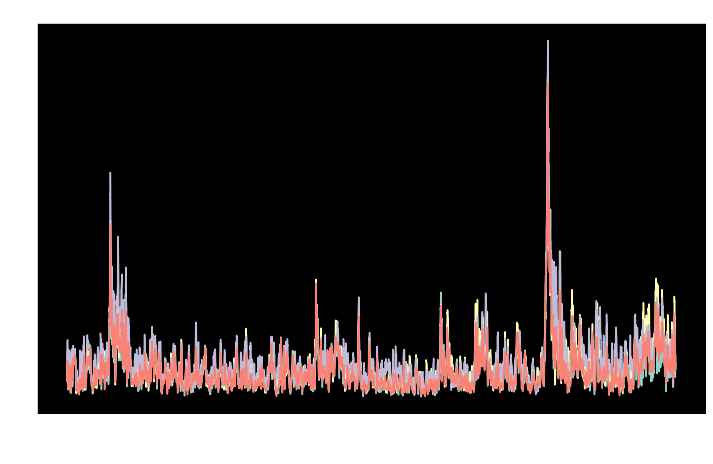

In [3]:
def plot_volatility(df):
    
    for column in df:
        if 'stdev' in column:
            df[column].plot(title=f'{df[column].name} Volatility', figsize=(12,8))
            
plot_volatility(volatility_df)

# volatility_df['stdev_DJI'].hvplot.line(title='DJI Volatility')

In [ ]:
def plot_grid(df, nrows, ncols):
    
    fix, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]]
        ax.plot(data, color='blue', linewidth=1)
        
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize=6)
        
    plt.tight_layout();

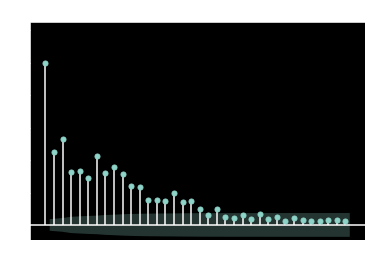

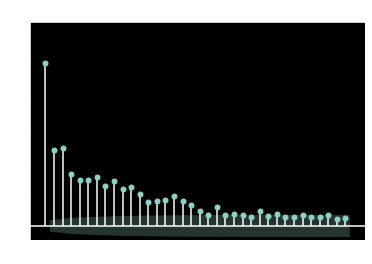

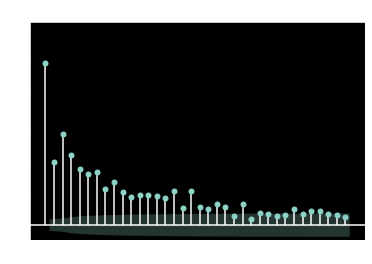

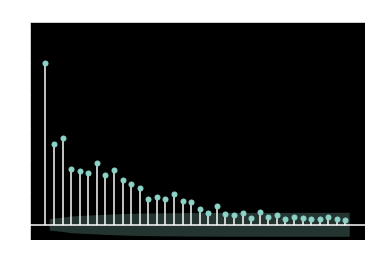

In [4]:
def plot_acf_squared(df):

    for column in df:
        if 'return' in column:
            plot_acf(np.power(df[column], 2), title=f'{df[column].name}^2 AutoCorrelation', auto_ylims=True);
            
plot_acf_squared(volatility_df)

## Volatility Prediction with VARMAX

In [82]:
DJI_OHLC_DF = pd.read_csv('./DATA/INDICES/DJI_OHLC.csv', parse_dates=True, infer_datetime_format=True, index_col="Date" )
# DJI_OHLC_DF = DJI_OHLC_DF.asfreq('D')
DJI_OHLC_DF = DJI_OHLC_DF.loc['2017-01-01':'2022-01-01']
DJI_OHLC_DF.head()

,Open,High,Low,Close
Date,,,,
2017-01-03,19872.86,19938.53,19775.93,19881.76
2017-01-04,19890.94,19956.14,19878.83,19942.16
2017-01-05,19924.56,19948.60,19811.12,19899.29
2017-01-06,19906.96,19999.63,19834.08,19963.80
2017-01-09,19931.41,19943.78,19887.38,19887.38


In [83]:
# Check stationarity
adfuller_res = adfuller(DJI_OHLC_DF['Close'].diff()[1:])

print(f'ADF Statistic: {adfuller_res[0]}')
print(f'p-value: {adfuller_res[1]}')

ADF Statistic: -11.005923122355057
p-value: 6.504655980059534e-20


In [84]:
scaler = MaxAbsScaler()
scaler.fit(DJI_OHLC_DF)
DJI_OHLC_scaled = scaler.transform(DJI_OHLC_DF)
DJI_OHLC_DF_scaled = pd.DataFrame(DJI_OHLC_scaled, columns=DJI_OHLC_DF.columns).dropna()
DJI_OHLC_DF_scaled.head()

,Open,High,Low,Close
0,0.544127,0.543589,0.543352,0.544875
1,0.544622,0.544069,0.546179,0.546531
2,0.545542,0.543863,0.544319,0.545356
3,0.545060,0.545255,0.544949,0.547124
4,0.545730,0.543732,0.546414,0.545030


In [93]:
model_var_DJI = VAR(DJI_OHLC_DF.diff()[1:])
sorted_order = model_var_DJI.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        41.66       41.68   1.239e+18       41.67
1        39.99       40.08   2.340e+17       40.03
2        39.47       39.62   1.391e+17       39.53
3        39.27       39.48   1.131e+17       39.35
4        39.21       39.49   1.067e+17       39.31
5        39.08       39.43   9.358e+16       39.21
6        38.95      39.36*   8.218e+16       39.10
7        38.91       39.39   7.905e+16       39.09
8        38.85       39.40   7.460e+16       39.06
9        38.81       39.42   7.155e+16       39.04
10       38.77       39.45   6.885e+16      39.03*
11       38.75       39.50   6.754e+16       39.03
12       38.73       39.55   6.627e+16       39.04
13       38.71       39.59   6.468e+16       39.04
14       38.71       39.66   6.477e+16       39.07
15       38.67       39.69   6.237e+16       39.05
16       38.66       39.74   6.

c:\Users\aglad\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [94]:
model_varmax_DJI = VARMAX(DJI_OHLC_DF.diff(),
                                #  freq='D',
                                 order=(6,0),
                                 error_cov_type='diagonal',
                                 enforce_stationarity=True
                                #  seasonal_order=(0,0,0,0),
                                #  mle_regression=True
                                #  filter_concentrated=True
                                 )

c:\Users\aglad\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [95]:
res_varmax_DJI = model_varmax_DJI.fit(maxiter=1000, disp=True)
print(res_varmax_DJI.summary())

c:\Users\aglad\anaconda3\envs\dev\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                  Statespace Model Results                                  
Dep. Variable:     ['Open', 'High', 'Low', 'Close']   No. Observations:                 1251
Model:                                       VAR(6)   Log Likelihood              -33967.863
                                        + intercept   AIC                          68143.727
Date:                              Wed, 28 Sep 2022   BIC                          68677.423
Time:                                      14:50:28   HQIC                         68344.353
Sample:                                           0                                         
                                             - 1251                                         
Covariance Type:                                opg                                         
Ljung-Box (L1) (Q):         nan, nan, nan, nan   Jarque-Bera (JB):   26977.94, 3605.49, 3428.44, 5400.80
Prob(Q):                    nan, nan, nan, nan   Prob(JB):

## Volatility Prediction with LSTM

In [2]:
DJI_OHLC_DF = pd.read_csv('./DATA/INDICES/DJI_OHLC.csv', parse_dates=True, infer_datetime_format=True, index_col="Date" )
# DJI_OHLC_DF = DJI_OHLC_DF.asfreq('D')
# DJI_OHLC_DF = DJI_OHLC_DF.loc['2017-01-01':'2022-01-01']
DJI_OHLC_DF.head()

,Open,High,Low,Close
Date,,,,
2010-09-30,10836.04,10948.88,10745.44,10788.05
2010-10-01,10789.70,10866.50,10780.60,10829.70
2010-10-04,10828.85,10853.71,10711.12,10751.27
2010-10-05,10752.78,10965.61,10752.63,10944.72
2010-10-06,10936.79,10974.16,10918.57,10967.65


In [5]:
scaler = StandardScaler()
scaler = scaler.fit(DJI_OHLC_DF)
DJI_OHLC_DF_scaled = scaler.transform(DJI_OHLC_DF)

In [9]:
X_train = []
y_train = []

n_future = 1 # Number of days we want to predict into the future
n_past = 14   # Number of past days we want to use to predict the future

for i in range(n_past, len(DJI_OHLC_DF_scaled) - n_future + 1):
    X_train.append(DJI_OHLC_DF_scaled[i - n_past:i, 0:DJI_OHLC_DF_scaled.shape[1]])
    y_train.append(DJI_OHLC_DF_scaled[i + n_future -1:i + n_future, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (2997, 14, 4)
y_train shape: (2997, 1)


In [15]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 14, 64)            17664     
                                                                 
 lstm_7 (LSTM)               (None, 14, 32)            12416     
                                                                 
 dropout (Dropout)           (None, 14, 32)            0         
                                                                 
 dense_2 (Dense)             (None, 14, 1)             33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
169/169 [==============================] - 3s 7ms/step - loss: 0.1588 - val_loss: 0.1631
Epoch 2/10
169/169 [==============================] - 1s 5ms/step - loss: 0.0365 - val_loss: 0.0547
Epoch 3/10
169/169 [==============================] - 1s 5ms/step - loss: 0.0228 - val_loss: 0.0361
Epoch 4/10
169/169 [==============================] - 1s 5ms/step - loss: 0.0217 - val_loss: 0.0317
Epoch 5/10
169/169 [==============================] - 1s 5ms/step - loss: 0.0214 - val_loss: 0.0268
Epoch 6/10
169/169 [==============================] - 1s 5ms/step - loss: 0.0209 - val_loss: 0.0366
Epoch 7/10
169/169 [==============================] - 1s 5ms/step - loss: 0.0204 - val_loss: 0.0234
Epoch 8/10
169/169 [==============================] - 1s 5ms/step - loss: 0.0200 - val_loss: 0.0214
Epoch 9/10
169/169 [==============================] - 1s 5ms/step - loss: 0.0205 - val_loss: 0.0219
Epoch 10/10
169/169 [==============================] - 1s 5ms/step - loss: 0.0198 - val_loss: 0.0221

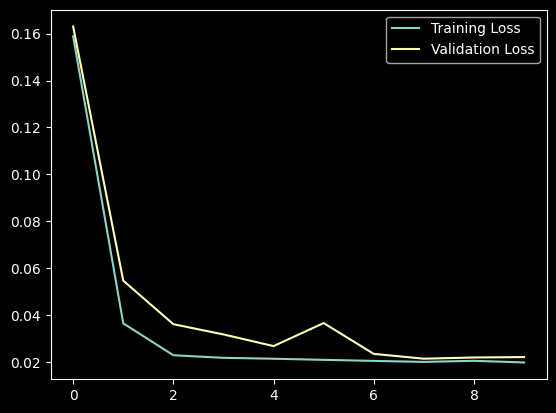

In [19]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [21]:
n_future = 90
forecast_period_dates = pd.date_range(list(DJI_OHLC_DF.index)[-1], periods=n_future, freq='1d').tolist()

In [22]:
forecast = model.predict(X_train[-n_future:])

3/3 [==============================] - 0s 3ms/step


In [30]:
forecast_copies = np.repeat(forecast, DJI_OHLC_DF.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

ValueError: Found array with dim 3. None expected <= 2.

In [25]:
forecast_copies

array([[[1.880759 , 1.880759 , 1.880759 , 1.880759 ],
        [1.7171808, 1.7171808, 1.7171808, 1.7171808],
        [1.6883385, 1.6883385, 1.6883385, 1.6883385],
        ...,
        [1.5548326, 1.5548326, 1.5548326, 1.5548326],
        [1.5743405, 1.5743405, 1.5743405, 1.5743405],
        [1.609109 , 1.609109 , 1.609109 , 1.609109 ]],

       [[1.8163433, 1.8163433, 1.8163433, 1.8163433],
        [1.6505932, 1.6505932, 1.6505932, 1.6505932],
        [1.7039038, 1.7039038, 1.7039038, 1.7039038],
        ...,
        [1.5754894, 1.5754894, 1.5754894, 1.5754894],
        [1.6101229, 1.6101229, 1.6101229, 1.6101229],
        [1.5361923, 1.5361923, 1.5361923, 1.5361923]],

       [[1.7253703, 1.7253703, 1.7253703, 1.7253703],
        [1.6725016, 1.6725016, 1.6725016, 1.6725016],
        [1.7460288, 1.7460288, 1.7460288, 1.7460288],
        ...,
        [1.6105908, 1.6105908, 1.6105908, 1.6105908],
        [1.5369205, 1.5369205, 1.5369205, 1.5369205],
        [1.4375302, 1.4375302, 1.437530